<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/CRVML/NN/DataFrameMakerML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [ ]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Mounted at /content/drive


In [ ]:
!pip install --upgrade tables
!pip install uproot3
import uproot3
import pandas as pd
import numpy as np

#Uproot and save training dataframe

In [ ]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [ ]:
fileH = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-hi.28PE.pulses.root")
fileL = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-lo.28PE.pulses.root")
fileB = uproot3.open("drive/MyDrive/root_files_oksuzian/ana.cele0s42b2.su2020v2.root")
trkanaH = fileH["TrkAnaNeg"]["trkana"]
trkanaL = fileL["TrkAnaNeg"]["trkana"]
trkanaB = fileB["TrkAnaNeg"]["trkana"]

In [ ]:
dfL_eve = trkanaL.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfL_crv = trkanaL.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfH_eve = trkanaH.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfH_crv = trkanaH.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfB_eve = trkanaB.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfB_crv = trkanaB.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfL_crv = dfL_crv[dfL_crv.index.get_level_values('subentry') == dfL_crv["bestcrv"]]
dfH_crv = dfH_crv[dfH_crv.index.get_level_values('subentry') == dfH_crv["bestcrv"]]
dfB_crv = dfB_crv[dfB_crv.index.get_level_values('subentry') == dfB_crv["bestcrv"]]

pd.merge(dfL_eve, dfL_crv, how="left", on='entry')
dfL = dfL_eve.merge(dfL_crv, how="left", on="entry")
dfH = dfH_eve.merge(dfH_crv, how="left", on="entry")
dfB = dfB_eve.merge(dfB_crv, how="left", on="entry")

dfH['is_high'] = 1
dfL['is_high'] = 0
dfB['is_high'] = -1

dfH['is_cosmic'] = 1
dfL['is_cosmic'] = 1
dfB['is_cosmic'] = 0

df = pd.concat([dfH, dfL, dfB], axis=0)
df["crvinfo__dT"] = df["crvinfo__timeWindowStart"] - df["de_t0"]
df['deent_d0_om'] = df["deent_d0"]+2.0/df["deent_om"]
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0

df = df.fillna(-999999)

del dfB_eve, dfB_crv, dfL_eve, dfL_crv, dfH_eve, dfH_crv, dfH, dfL, dfB



/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block6_values] [items->Index(['crvinfomc__valid'], dtype='object')]

  encoding=encoding,


In [ ]:
#Smear z to reduce oversampling spikes
MINZ = df.query('crvinfo__PEs>0')['crvinfo__z'].min()
MAXZ = df.query('crvinfo__PEs>0')['crvinfo__z'].max()

def smear(z):
  zsmear = np.random.normal(z, 100)
  if zsmear > MINZ and zsmear < MAXZ:
    return zsmear
  else:
    return z 

df['crvinfo__zSmear'] = df['crvinfo__z'].apply(smear)

In [ ]:
df.to_hdf(main_path+"Saved_Data/TrainingDataCRY3CE.h5", key='df', mode='w')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block6_values] [items->Index(['crvinfomc__valid'], dtype='object')]

  encoding=encoding,


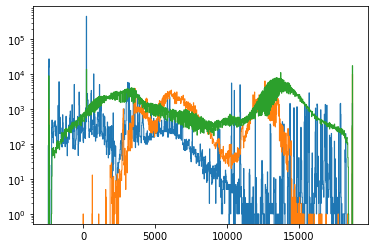

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df.query('is_high==-1 & crvinfo__z>-10000')['crvinfo__z'], bins=1000, histtype='step');
plt.hist(df.query('is_high==0  & crvinfo__z>-10000')['crvinfo__z'], bins=1000, histtype='step');
plt.hist(df.query('is_high==1  & crvinfo__z>-10000')['crvinfo__z'], bins=1000, histtype='step');
plt.yscale('log')